In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
## code for SeabornFig2Grid 
import sfg

## Load Data
Data was downloaded from https://www.kaggle.com/c/liverpool-ion-switching in June 2020.

*Note: While the time series appears continuous, the data is from discrete batches of 50 seconds long 10 kHz samples (500,000 rows per batch). In other words, the data from 0.0001 - 50.0000 is a different batch than 50.0001 - 100.0000, and thus discontinuous between 50.0000 and 50.0001.* [cited from [kaggle.com](https://www.kaggle.com/c/liverpool-ion-switching)]

In [3]:
df = pd.read_csv('../Data/train.csv', index_col=None)
df.head(3)

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0


#### Check dimension of dataset

In [4]:
df.shape

(5000000, 3)

#### Check for missing values

In [5]:
df.isnull().sum()

time             0
signal           0
open_channels    0
dtype: int64

## Data Preprocessing: Get to know the data and preprocess 
#### Create new features *batch* for each batch and *time50* for the time intervals from 0 to 50 seconds
Every 50 seconds presents one batch.

In [6]:
## batch column 
batches = (divmod(df['time']-0.0001, 50)[0] + 1).astype(int)
df.insert(loc=0, column="batch", value=batches)

## column for 50s time intervals 
time_interval50s = df['time']-(df['batch']-1)*50
df.insert(loc=1, column="time50", value=time_interval50s)
# df = df.drop(['time'], axis=1)

df.tail()

,batch,time50,time,signal,open_channels
4999995,10,49.9996,499.9996,2.9194,7
4999996,10,49.9997,499.9997,2.6980,7
4999997,10,49.9998,499.9998,4.5164,8
4999998,10,49.9999,499.9999,5.6397,9
4999999,10,50.0000,500.0000,5.3792,9


### Get familiar with the data: Visualize

#### Density plot: Signal per batch

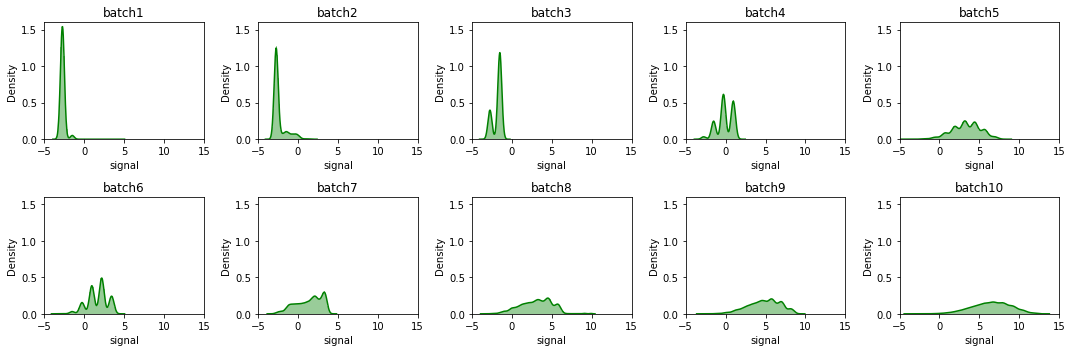

In [7]:
plt.figure(figsize=(15,5))
for i in df['batch'].unique():    
    plt.subplot(2,5,i)
    sns.distplot(df['signal'][df['batch']==i], color='g')  
    plt.xlabel('signal')
    plt.title('batch' + str(i))
    plt.xlim([-5,15])
    plt.ylim([0,1.6])
    plt.tight_layout()  

#### Violin plot: Signal per batch
kernel density estimation of underlying distribution (quartiles are displayed)

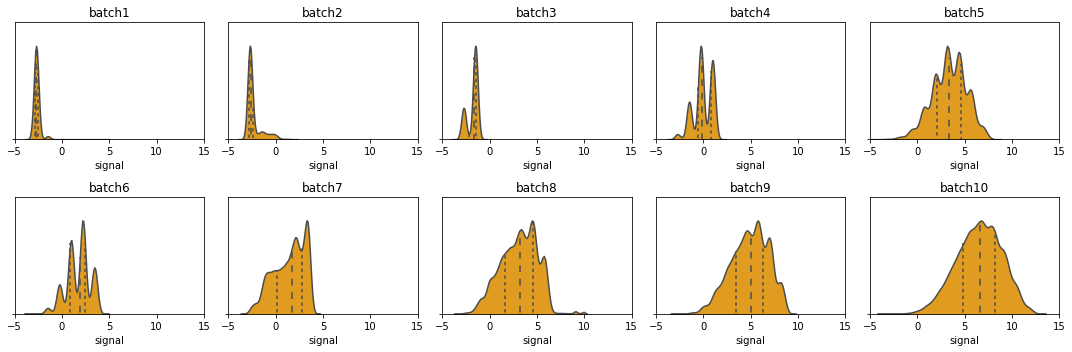

In [8]:
plt.figure(figsize=(15,5))
for i in df['batch'].unique():    
    plt.subplot(2,5,i)
    sns.violinplot(df['signal'][df['batch']==i], color='orange', inner="quartile")  
    plt.xlabel('signal')
    plt.title('batch' + str(i))
    plt.xlim([-5,15])
    plt.ylim([0, 0.5])
    plt.tight_layout()  

#### Boxplot: Signal per batch (left), Open channels per batch (right)

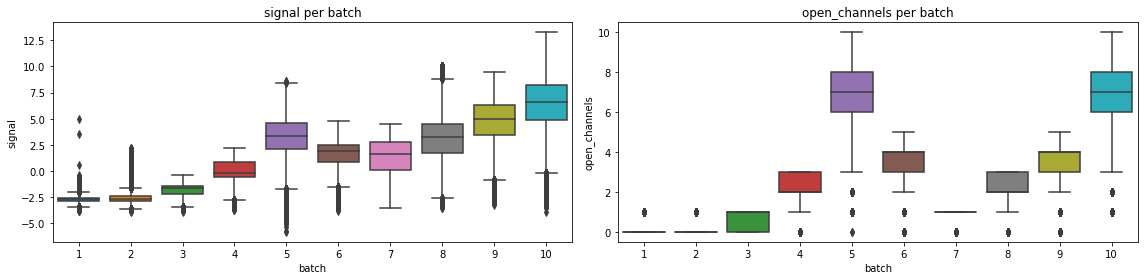

In [9]:
plot_list = ['signal','open_channels']
plt.figure(figsize=(16,4))
for i,elem in enumerate(plot_list,1):    
    plt.subplot(1,2,i)
    sns.boxplot(x='batch', y=elem, data=df)
    plt.xlabel('batch')
    plt.ylabel(elem)
    plt.title(elem + " per batch")
    plt.tight_layout() 

#### Jointplot: Signal over time

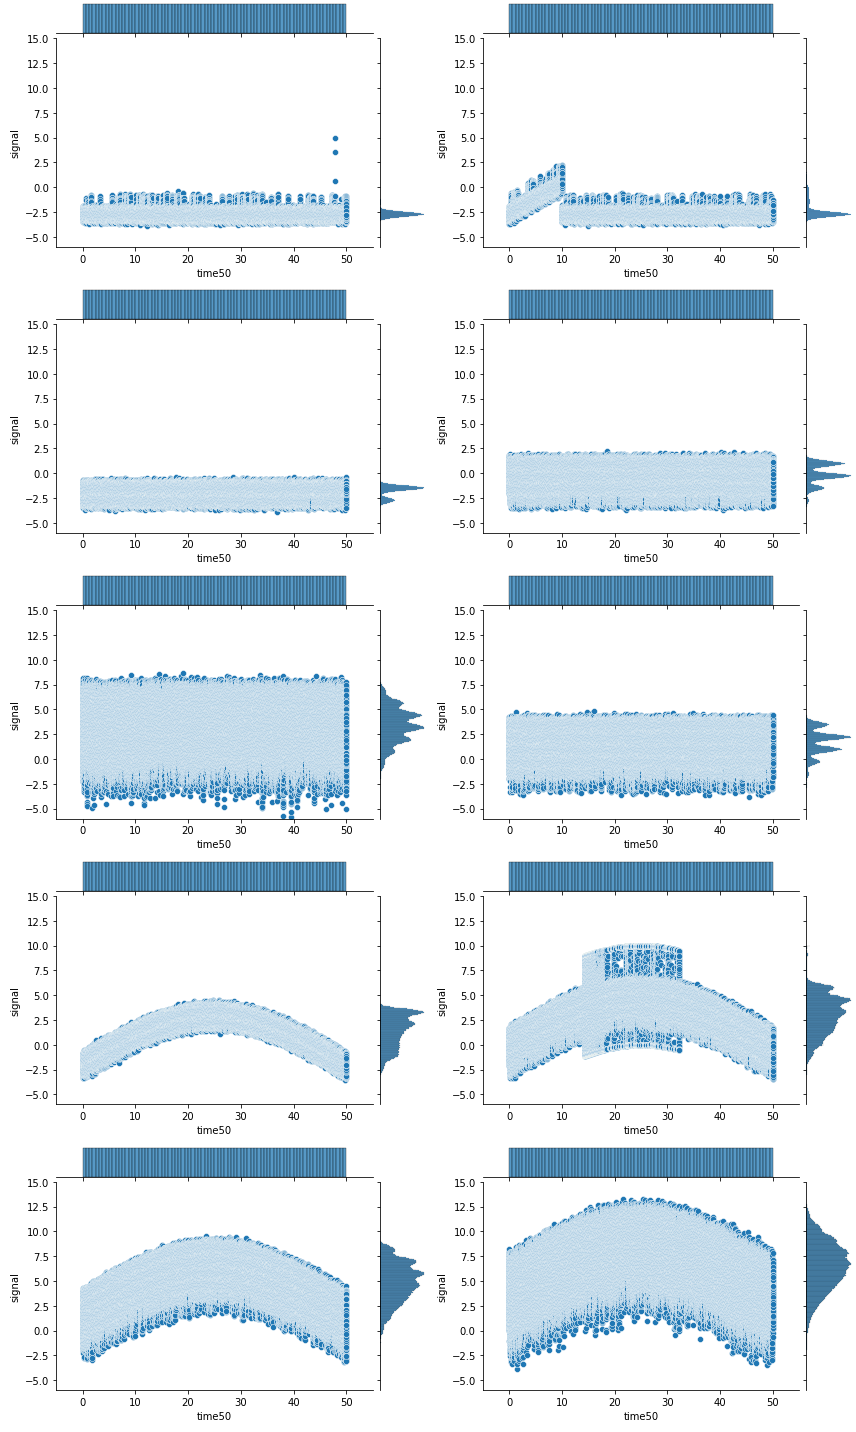

In [10]:
fig = plt.figure(figsize=(12, 20), tight_layout=True)
gs = gridspec.GridSpec(5, 2)

for i in range(1,11):
    sfg.SeabornFig2Grid(sns.jointplot(data=df[df['batch']==i], 
                                      x='time50', y='signal',
                                      xlim=(-5,55), ylim=(-6,15)), fig, gs[i-1])

#### Signal (blue) and open channels (red) over time

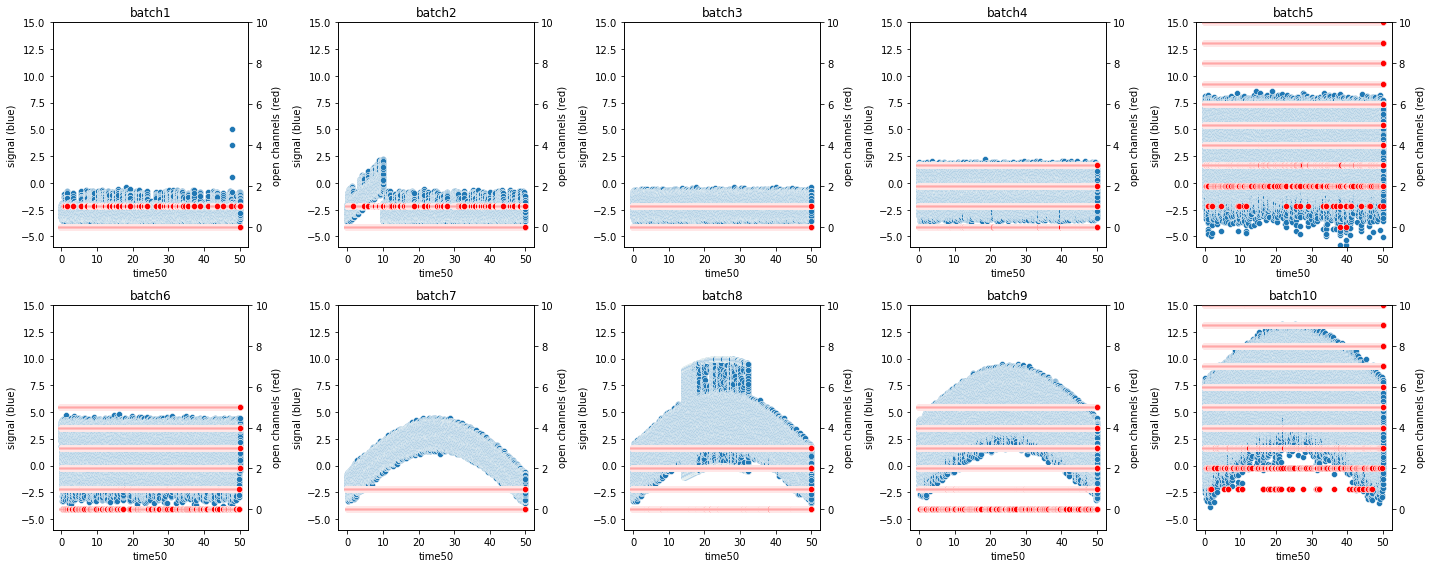

In [11]:
plt.figure(figsize=(20,8))
for i in df['batch'].unique():    
    plt.subplot(2,5,i)     
    
    ax = sns.scatterplot(x='time50', y='signal', data=df[df['batch']==i]) 
    plt.ylim([-6,15])
    plt.ylabel("signal (blue)")

    ax2 = ax.twinx()
    ax2 = sns.scatterplot(x='time50', y='open_channels', data=df[df['batch']==i], color='red')
    plt.ylim([-1,10])
    plt.ylabel("open channels (red)")
    
    plt.title('batch' + str(i))
    plt.tight_layout()

#### Create a subset and display all observations for a certain time
This is exemplary to get to know the data

In [12]:
df_subset = df[["open_channels", "batch", "time50", "signal"]]
df_subset.loc[df_subset["time50"] == 40.03]

,open_channels,batch,time50,signal
400299,0,1,40.03,-2.2829
900299,0,2,40.03,-2.8413
1400299,0,3,40.03,-2.2220
1900299,2,4,40.03,-0.2165
2400299,10,5,40.03,7.0392


In [19]:
df_subset = df[["open_channels", "batch", "time50", "signal"]]
df_subset.loc[df_subset["time50"] == 40.06]

,open_channels,batch,time50,signal
400599,0,1,40.06,-2.9330
900599,0,2,40.06,-3.1628
1400599,0,3,40.06,-2.5316
1900599,3,4,40.06,1.2845
2400599,7,5,40.06,3.3472
2900599,5,6,40.06,3.7749
3400599,1,7,40.06,1.2264
3900599,2,8,40.06,2.5240
4400599,4,9,40.06,5.6170
4900599,8,10,40.06,6.7101


#### Boxplot: signal ~ open_channels

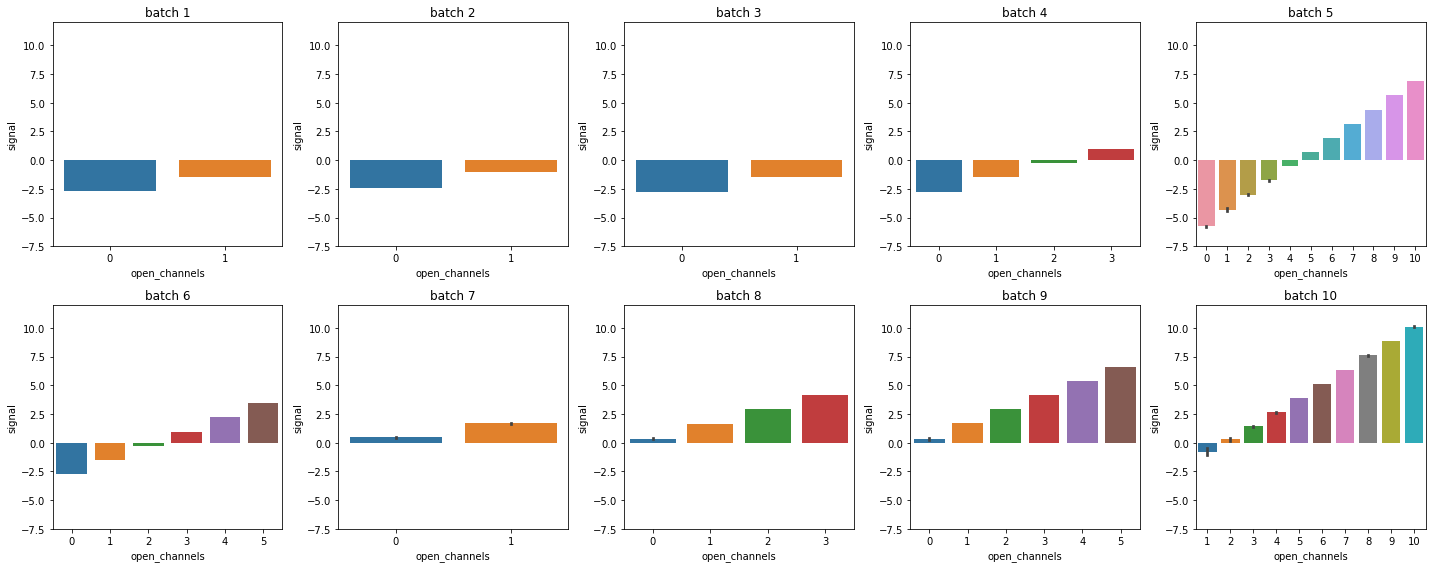

In [56]:
plt.figure(figsize=(20,8))
for i in df['batch'].unique():    
    plt.subplot(2,5,i)
    sns.barplot(x='open_channels', y='signal', data=df[df['batch']==i])            
    plt.title('batch ' + str(i))
    plt.ylim([-7.5,12])
    plt.tight_layout()

### Create new feature for delta *signal* 
Remove trend to get time series stationary. \
signal_timeDelta: $signal_t - signal_{t-1}$

In [21]:
df['signal_timeDelta'] = df['signal'].diff()
df['signal_timeDelta'].fillna(method='backfill', inplace=True)
df.head(3)

,batch,time50,time,signal,open_channels,signal_width,channel_pattern,signal_timeDelta
0,1,0.0001,0.0001,-2.7600,0,0,1,-0.0957
1,1,0.0002,0.0002,-2.8557,0,0,1,-0.0957
2,1,0.0003,0.0003,-2.4074,0,0,1,0.4483


#### Eliminate outliers in signal_timeDelta batch-wise

In [22]:
for elem in df['batch'].unique():
    x = df['signal_timeDelta'][df['batch'] == elem]
    q_hi  = x.quantile(0.999)
    q_low = x.quantile(0.001)    
    df['signal_timeDelta'][(df['batch'] == elem) & (df['signal_timeDelta'] > q_hi)] = q_hi
    df['signal_timeDelta'][(df['batch'] == elem) & (df['signal_timeDelta'] < q_low)] = q_low

#### Plot signal_timeDelta without outliers (blue) and open_channels (red) ~ signals per batch

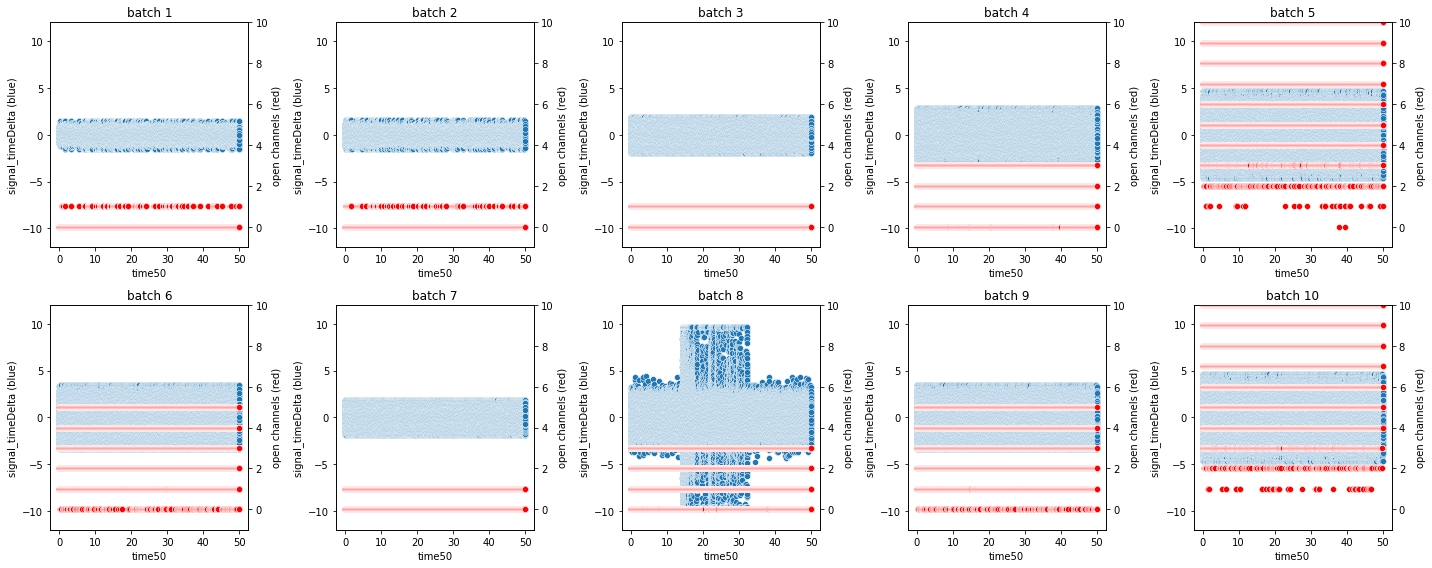

In [23]:
plt.figure(figsize=(20,8))
for i in df['batch'].unique():     
    plt.subplot(2,5,i)
    ax = sns.scatterplot(x='time50', y='signal_timeDelta', data=df[df['batch']==i]) 
    plt.ylim([-12,12])
    plt.ylabel("signal_timeDelta (blue)")
    
    ax2 = ax.twinx()
    ax2 = sns.scatterplot(x='time50', y='open_channels', data=df[df['batch']==i], color="red")
    plt.ylim([-1,10])
    plt.ylabel("open channels (red)")
    
    plt.title('batch ' + str(i))
    plt.tight_layout() 

Batch 8 looks like not being stationary because variance is obviously not constant over time.

#### Boxplot: signal_timeDelta ~ open_channels

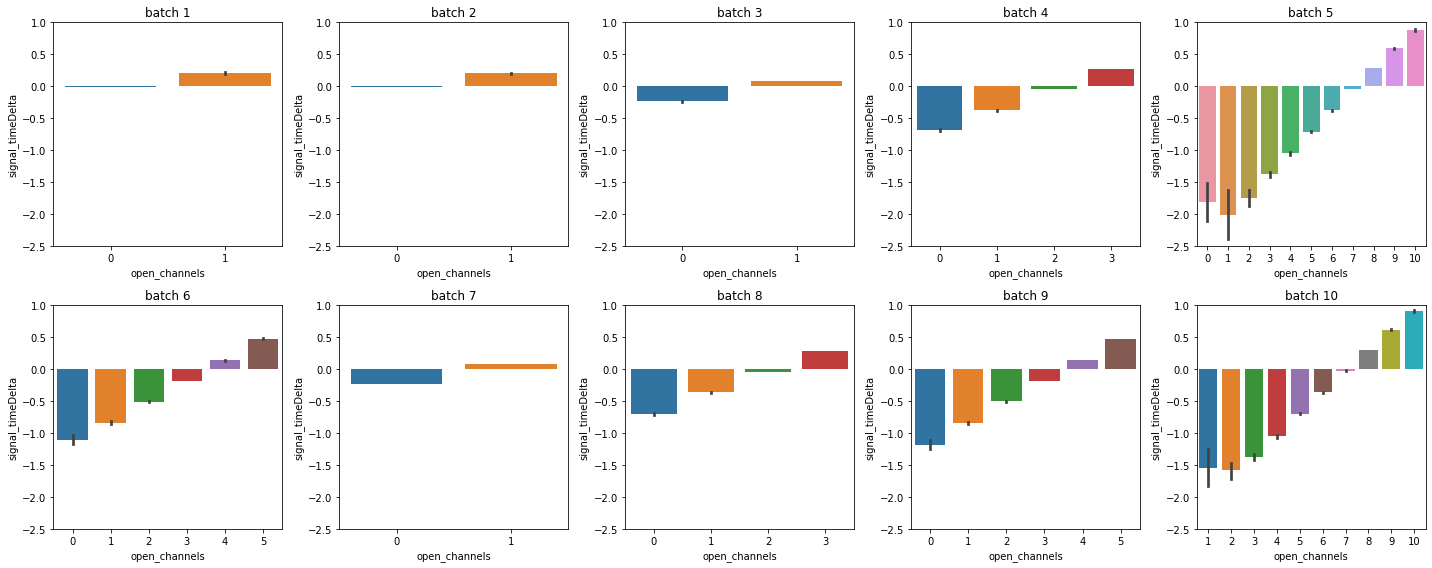

In [24]:
plt.figure(figsize=(20,8))
for i in df['batch'].unique():    
    plt.subplot(2,5,i)
    sns.barplot(x='open_channels', y='signal_timeDelta', data=df[df['batch']==i])            
    plt.title('batch ' + str(i))
    plt.ylim([-2.5,1.0])
    plt.tight_layout()

#### Create a new feature for *channel pattern*
Batches 1 and 2, batches 3 and 7, batches 4 and 8 as well as batches 6 and 9 share a similar patterns concerning channels. 

In [26]:
df['channel_pattern'] = 0
channel_pattern_dict = {1:1, 2:1, 3:2, 4:3, 5:4, 6:5, 7:2, 8:3, 9:5, 10:6}
for i in df['batch'].unique():
    for key,value in channel_pattern_dict.items():
        if df['batch'][i] == key:
            df['channel_pattern'][df['batch']==i] = channel_pattern_dict.get(i) 
df.tail()

,batch,time50,time,signal,open_channels,signal_width,channel_pattern,signal_timeDelta
4999995,10,49.9996,499.9996,2.9194,7,9.286804,6,-1.4519
4999996,10,49.9997,499.9997,2.6980,7,9.286804,6,-0.2214
4999997,10,49.9998,499.9998,4.5164,8,9.286804,6,1.8184
4999998,10,49.9999,499.9999,5.6397,9,9.286804,6,1.1233
4999999,10,50.0000,500.0000,5.3792,9,9.286804,6,-0.2605


#### Create new feature *signal width*

In [43]:
df['signal_width'] = 0
for elem in df['batch'].unique():
    max_time = df['signal_timeDelta'][df['batch'] == elem].max()
    min_time = df['signal_timeDelta'][df['batch'] == elem].min()    
    df['signal_width'][df['batch'] == elem] = max_time - min_time    
df.head()

,batch,time50,time,signal,open_channels,signal_width,channel_pattern,signal_timeDelta
0,1,0.0001,0.0001,-2.7600,0,3.032101,1,-0.0957
1,1,0.0002,0.0002,-2.8557,0,3.032101,1,-0.0957
2,1,0.0003,0.0003,-2.4074,0,3.032101,1,0.4483
3,1,0.0004,0.0004,-3.1404,0,3.032101,1,-0.7330
4,1,0.0005,0.0005,-3.1525,0,3.032101,1,-0.0121


#### Barplot: Signal_width per batch-wise

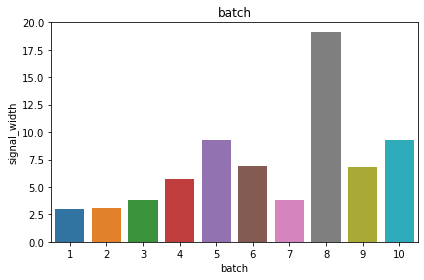

In [46]:
sns.barplot(x='batch', y='signal_width', data=df)            
plt.title('batch')
plt.ylim([0,20])
plt.tight_layout()

#### Analyze correlation between time and signal per batch

In [53]:
def correlationMatrix(batch):
    corr_time_signal = df[["time50", "signal"]][df["batch"]==batch].corr()
    print("Batch:", batch)
    print(corr_time_signal, "\n")
    
for i in range(1,11):
    correlationMatrix(i)

Batch: 1
         time50   signal
time50  1.00000 -0.03217
signal -0.03217  1.00000 

Batch: 2
          time50    signal
time50  1.000000 -0.483681
signal -0.483681  1.000000 

Batch: 3
          time50    signal
time50  1.000000  0.004202
signal  0.004202  1.000000 

Batch: 4
          time50    signal
time50  1.000000  0.002593
signal  0.002593  1.000000 

Batch: 5
          time50    signal
time50  1.000000  0.018038
signal  0.018038  1.000000 

Batch: 6
          time50    signal
time50  1.000000 -0.006053
signal -0.006053  1.000000 

Batch: 7
          time50    signal
time50  1.000000 -0.002146
signal -0.002146  1.000000 

Batch: 8
         time50   signal
time50  1.00000  0.00631
signal  0.00631  1.00000 

Batch: 9
          time50    signal
time50  1.000000 -0.000674
signal -0.000674  1.000000 

Batch: 10
          time50    signal
time50  1.000000  0.008913
signal  0.008913  1.000000 



#### Plot correlations in a heatmap

In [51]:
df_reordered = df.reindex(columns = ["open_channels", "batch", "time", "time50", "signal", 
                                     "signal_timeDelta", "signal_width", "channel_pattern"])
df_reordered.head()

,open_channels,batch,time,time50,signal,signal_timeDelta,signal_width,channel_pattern
0,0,1,0.0001,0.0001,-2.7600,-0.0957,3.032101,1
1,0,1,0.0002,0.0002,-2.8557,-0.0957,3.032101,1
2,0,1,0.0003,0.0003,-2.4074,0.4483,3.032101,1
3,0,1,0.0004,0.0004,-3.1404,-0.7330,3.032101,1
4,0,1,0.0005,0.0005,-3.1525,-0.0121,3.032101,1


<AxesSubplot:>

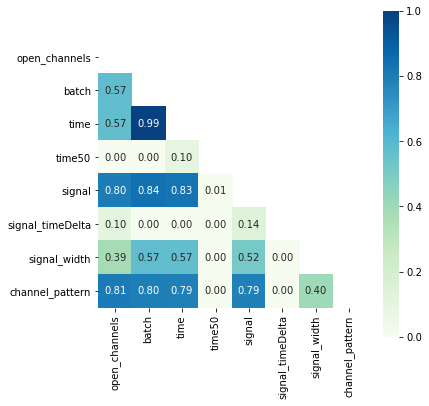

In [52]:
mask = np.triu(np.ones_like(df_reordered.corr().abs(), dtype=np.bool))
plt.figure(figsize=(6,6))
sns.heatmap(df_reordered.corr().abs(), mask=mask, cmap='GnBu', 
            vmax=1, square=True, annot=True, fmt='.2f') 

#### Descriptive Statistics

In [14]:
df.describe(include='all')

,signal,open_channels,batch,time50,signal_timeDelta,channel_pattern,signal_width
count,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06,5.000000e+06
mean,1.386246e+00,2.726043e+00,5.500000e+00,2.500005e+01,5.533620e-06,3.200000e+00,7.095273e+00
std,3.336219e+00,2.665051e+00,2.872282e+00,1.443376e+01,9.146314e-01,1.661325e+00,4.595873e+00
min,-5.796500e+00,0.000000e+00,1.000000e+00,1.000000e-04,-9.554908e+00,1.000000e+00,3.032101e+00
25%,-1.594800e+00,1.000000e+00,3.000000e+00,1.250007e+01,-3.792000e-01,2.000000e+00,3.792101e+00
50%,1.124000e+00,2.000000e+00,5.500000e+00,2.500005e+01,-5.000000e-04,3.000000e+00,6.291303e+00
75%,3.690100e+00,4.000000e+00,8.000000e+00,3.750002e+01,3.781000e-01,5.000000e+00,9.280902e+00
max,1.324400e+01,1.000000e+01,1.000000e+01,5.000000e+01,9.610505e+00,6.000000e+00,1.916541e+01


#### Save DataFrame

In [53]:
df.to_csv('../Data/df_preprocessed.csv', index=False)